# New Section

In [ ]:
%matplotlib inline
import nltk
from gensim.models import Word2Vec, KeyedVectors
import numpy as np
import pandas as pd
import sqlite3
import re
import matplotlib.pyplot as plt
#import nbconvert
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
%cd /gdrive/My Driv/SM_FRIEND_NEWSDATA

/gdrive/My Drive/SM_FRIEND_NEWSDATA


In [ ]:
#new clean data
data = pd.read_csv('finalsamit_data.csv').apply(lambda x: x.astype(str).str.lower())

In [ ]:
data.drop_duplicates(keep=False, inplace=True)

In [ ]:
stopwords = pd.read_csv('Stopwords.csv')

def to_encode(bangla_word):
    return bangla_word.encode('utf-8')


def to_decode(bangla_word):
    return bangla_word.decode('utf-8')

set_stop = set(stopwords['words'].map(to_encode))

In [ ]:
from bengali_stemmer.rafikamal2014 import RafiStemmer
stemmer = RafiStemmer()

texts = data['text'].values

In [ ]:
import re
def cleanhtml(sentence):
    cleanr1 = re.compile('/.*?')
    cleantext = re.sub(cleanr1,' ',sentence)
    cleanr = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    cleantext = re.sub(cleanr,' ',sentence)
    return cleantext

In [ ]:

def clean_punct(sentence):
    cleaned = re.sub(r'[?|!|\'|"|#|।|’|‘]', r'', sentence)
    cleaned1 = re.sub(r'[.|,|(|)|\|/]', r'', cleaned)
    cleaned = re.sub(r'[০|১|২|৩|৪|৫|৬|৭|৮|৯]', r'', cleaned1)
    cleaned1 = re.sub(r'[-|=]', r' ', cleaned)
    cleaned = re.sub(r'[A|B|C|D|E|F|G|H|I|J|K|L|M|N|O|P|Q|R|S|T|U|V|W|X|Y|Z|a|b|c|d|e|f|g|h|i|j|k|l|m|n|o|p|q|r|s|t|u|v|w|x|y|z]', r'', cleaned1)
    cleaned1 = re.sub(r'[1|2|3|4|5|6|7|8|9|0]', r'', cleaned)
    return cleaned1

In [ ]:
def pre_process(data):
    i=0
    str1=' '
    final_string = []
    final_words = []
    
    s=''

    for sentence in data:
        filtered_sentence = []

        for w in sentence.split():
            for cleaned_word1 in cleanhtml(w).split():
                for cleaned_word in clean_punct(cleaned_word1).split():
                    if len(cleaned_word)>2:
                        if(to_encode(cleaned_word) not in set_stop):
                            s = stemmer.stem_word(cleaned_word)
                            if len(s)>2:
                                final_words.append(s)
                                filtered_sentence.append(s)
                        else:
                            continue
                    else:
                        continue

        str1 = " ".join(filtered_sentence)
        final_string.append(str1)
    return final_string

In [ ]:
X = pre_process(data['text'].values)
#y = data['label'].values

In [ ]:
Y = data['label'].values

In [ ]:
from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, shuffle=Flase)# this is for time series split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33,random_state=42) # this is random splitting
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33,random_state=42) # this is random splitting

In [ ]:
label=np.unique(y_train)

label

array(['eco', 'ent', 'int', 'sprt', 'state'], dtype=object)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
#vectorizer.fit(X_train) # fit has to happen only on train data

W2VEC MODEL

In [ ]:
i=0
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())

In [ ]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [ ]:
# this line of code trains your w2v model on the give list of sentances
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=300, workers=10)

In [ ]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  102177
sample words  ['মৌলভীবাজার', 'কমলগঞ্জ', 'উপজেলা', 'পুকুর', 'ডুব', 'সুমাইয়া', 'বেগম', 'নাম', 'দেড়', 'বছর', 'শিশুর', 'মৃত্যু', 'গতকাল', 'বেলা', 'দুই', 'আলীনগর', 'ইউনিয়ন', 'গ্রাম', 'ঘটনা', 'শিশু', 'পরিব', 'সূত্র', 'উপজেল', 'বস্তির', 'ইসমত', 'মিয়', 'শিশুকন্যা', 'মায়', 'মামা', 'তাহির', 'বাড়ি', 'বেড়া', 'দুপুর', 'অজান্', 'বাড়ির', 'পেছন', 'পানি', 'পড়', 'আধা', 'ঘণ্', 'পরিবার', 'লোকজন', 'মৃতদেহ', 'ভাস', 'দেখ', 'সাভার', 'রানা', 'প্লাজা', 'ঘটনায়', 'হত্যা']


In [ ]:
from tqdm import tqdm
import numpy as np

CONVERT TRAINDATA TEXT

In [ ]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(300) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
sent_vectors_train = np.array(sent_vectors)
#print(np.asarray(sent_vectors).shape)
#print(sent_vectors[0])

#print(np.asarray(X).shape)

100%|██████████| 167759/167759 [1:52:52<00:00, 24.77it/s]


CONVERTING CV DATA TEXT

In [ ]:
i=0
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())

In [ ]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_cv): # for each review/sentence
    sent_vec = np.zeros(300) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
sent_vectors_cv = np.array(sent_vectors_cv)
#print(np.asarray(sent_vectors_cv).shape)
#print(sent_vectors_cv[0])

100%|██████████| 82628/82628 [57:41<00:00, 23.87it/s]


CONVERTING TEST DATA TEXT

In [ ]:
i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())

In [ ]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(300) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
sent_vectors_test = np.array(sent_vectors_test)
#print(np.asarray(sent_vectors_test).shape)
#print(sent_vectors_test[0])

100%|██████████| 123325/123325 [1:25:22<00:00, 24.08it/s]


FIT WITH A MODEL 
# **GaussianNB classifier**

In [ ]:
from sklearn . naive_bayes import GaussianNB
from sklearn import metrics
from sklearn . metrics import accuracy_score
from sklearn . model_selection import cross_val_score

In [ ]:
Gmodel = GaussianNB() . fit ( sent_vectors , y_train )

 #neigh.fit(sent_vectors_train, y_train)

# *Cross validation for gaussian nb*

In [ ]:
#using k-fold

accuracy = cross_val_score(Gmodel, sent_vectors_cv, y_cv, scoring='accuracy', cv = 10)
print(accuracy)

[0.85320102 0.84739199 0.8486022  0.8502965  0.84376135 0.85404817
 0.84509258 0.84485054 0.85027838 0.84846284]


In [ ]:
print("Accuracy of Model with Cross Validation is:",accuracy.mean() * 100)

Accuracy of Model with Cross Validation is: 84.85985567133592


In [ ]:
#using cross_validate() function

from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score
scoring = ['precision_macro', 'recall_macro']
scores = cross_validate(Gmodel, sent_vectors_cv, y_cv, scoring=scoring)
sorted(scores.keys())

['fit_time', 'score_time', 'test_precision_macro', 'test_recall_macro']

In [ ]:
scores['test_recall_macro']

array([0.88671576, 0.88210566, 0.88434591, 0.87941815, 0.88469419])

# *accuracy for test data*

In [ ]:
from sklearn . metrics import classification_report

In [ ]:

y_test_pred  = Gmodel . predict ( sent_vectors_test )


In [ ]:
#trainig accuracy for gaussian neigh bayes
y_train_pred = Gmodel . predict(sent_vectors)
print ( 'Model accuracy %s' % accuracy_score ( y_train , y_train_pred ) )

Model accuracy 0.8489559427512086


In [ ]:

print ( 'Model accuracy %s' % accuracy_score ( y_test , y_test_pred ) )
print ( 'accuracy normalized %s' % accuracy_score ( y_test , y_test_pred , normalize = False ) )
print ( classification_report ( y_test , y_test_pred ) )

#xlabels . append ( "Gaussian" )
#ylabels . append ( accuracy_score ( y_test , y_test_pred ) ) 

Model accuracy 0.8486438272856274
accuracy normalized 104659
              precision    recall  f1-score   support

         eco       0.45      0.91      0.60      6189
         ent       0.74      0.92      0.82     10005
         int       0.59      0.87      0.70     10560
        sprt       0.99      0.91      0.95     16643
       state       0.97      0.82      0.89     79928

    accuracy                           0.85    123325
   macro avg       0.75      0.89      0.79    123325
weighted avg       0.90      0.85      0.86    123325



In [ ]:
print(label)

['eco' 'ent' 'int' 'sprt' 'state']


In [ ]:
label=np.array(['economics', 'entertainment', 'international', 'sports', 'state'], dtype=object)

Confusion matrix, without normalization
[[ 5638    63   140     3   345]
 [   72  9183   230    60   460]
 [  216   436  9144    11   753]
 [  143   439   504 15212   345]
 [ 6501  2301  5549    95 65482]]
Normalized confusion matrix
[[9.11e-01 1.02e-02 2.26e-02 4.85e-04 5.57e-02]
 [7.20e-03 9.18e-01 2.30e-02 6.00e-03 4.60e-02]
 [2.05e-02 4.13e-02 8.66e-01 1.04e-03 7.13e-02]
 [8.59e-03 2.64e-02 3.03e-02 9.14e-01 2.07e-02]
 [8.13e-02 2.88e-02 6.94e-02 1.19e-03 8.19e-01]]


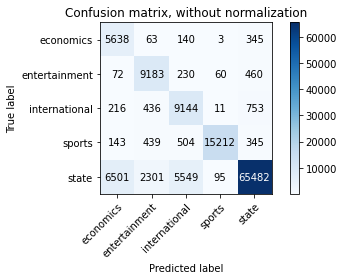

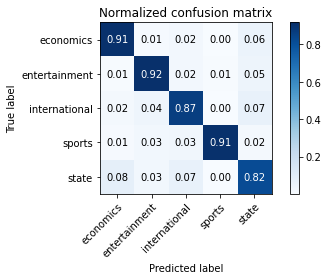

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_test, y_test_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=label, yticklabels=label,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.xlim(-0.5, len(np.unique(y_test))-0.5) # ADD THIS LINE
    plt.ylim(len(np.unique(y_test))-0.5, -0.5) # ADD THIS LINE
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_test_pred, classes=label,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_test_pred, classes=label, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

# **SVM classifier**

In [ ]:
import sklearn
from sklearn import svm
from sklearn . model_selection import cross_val_score

In [ ]:
smodel = svm . SVC ( C = 3, gamma = 'scale', kernel = 'rbf' )

smodel . fit ( sent_vectors , y_train )



SVC(C=3, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

# *Cross validation score for svm*

In [ ]:
#using k-fold

accuracy = cross_val_score(smodel, sent_vectors_cv, y_cv, scoring='accuracy', cv = 10)
print(accuracy)

#get the mean of each fold 
#print("Accuracy of Model with Cross Validation is:",accuracy.mean() * 100)

[0.96 0.96 0.96 0.96 0.96 0.96 0.96 0.96 0.96 0.96]


In [ ]:
print("Accuracy of Model with Cross Validation is:",accuracy.mean() * 100)

Accuracy of Model with Cross Validation is: 96.22403704550356


**Train** **accuracy**

In [ ]:
y_train_pred  = smodel . predict ( sent_vectors )

In [ ]:
print ( 'Model accuracy %s' % accuracy_score (  y_train , y_train_pred ) )

Model accuracy 0.9776763094677484


# *accuracy score for test data*

In [ ]:
from sklearn . metrics import classification_report
y_test_pred  = smodel . predict ( sent_vectors_test )
#y_cv_pred = smodel . predict(sent_vectors_cv)

In [ ]:
label=np.unique(y_train)

In [ ]:
print ( 'Model accuracy %s' % accuracy_score ( y_test , y_test_pred ) )
print ( 'accuracy normalized %s' % accuracy_score ( y_test , y_test_pred , normalize = False ) )
print ( classification_report ( y_test , y_test_pred ) )

Model accuracy 0.9662679910804784
accuracy normalized 119165
              precision    recall  f1-score   support

         eco       0.83      0.83      0.83      6189
         ent       0.94      0.94      0.94     10005
         int       0.95      0.94      0.95     10560
        sprt       0.99      0.99      0.99     16643
       state       0.98      0.98      0.98     79928

    accuracy                           0.97    123325
   macro avg       0.94      0.94      0.94    123325
weighted avg       0.97      0.97      0.97    123325



Confusion matrix, without normalization
[[ 5117     9    70     9   984]
 [   16  9448    75    47   419]
 [   66   126  9963    31   374]
 [    8    57    30 16467    81]
 [  928   412   320    98 78170]]
Normalized confusion matrix
[[8.27e-01 1.45e-03 1.13e-02 1.45e-03 1.59e-01]
 [1.60e-03 9.44e-01 7.50e-03 4.70e-03 4.19e-02]
 [6.25e-03 1.19e-02 9.43e-01 2.94e-03 3.54e-02]
 [4.81e-04 3.42e-03 1.80e-03 9.89e-01 4.87e-03]
 [1.16e-02 5.15e-03 4.00e-03 1.23e-03 9.78e-01]]


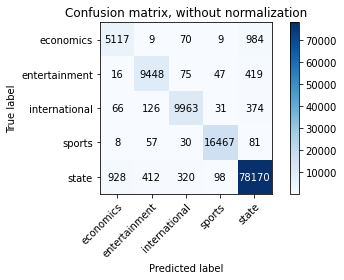

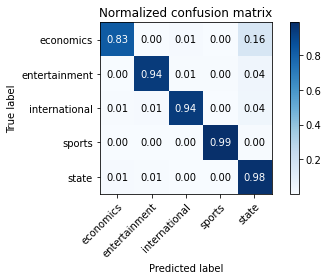

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_test, y_test_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=label, yticklabels=label,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.xlim(-0.5, len(np.unique(y_test))-0.5) # ADD THIS LINE
    plt.ylim(len(np.unique(y_test))-0.5, -0.5) # ADD THIS LINE
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_test_pred, classes=label,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_test_pred, classes=label, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

# **logistic regression**

In [ ]:
from sklearn.linear_model import LogisticRegression
Lmodel = LogisticRegression ( multi_class = 'ovr' , solver = 'lbfgs' )

In [ ]:
Lmodel . fit ( sent_vectors , y_train )

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

## cross validation score for logistic regression 

In [ ]:
from sklearn import metrics
from sklearn . metrics import accuracy_score
from sklearn . model_selection import cross_val_score
accuracy = cross_val_score(Lmodel, sent_vectors_cv, y_cv, scoring='accuracy', cv = 10)
print(accuracy)

[0.95691637 0.94832385 0.95134939 0.95268062 0.95304369 0.95147041
 0.95134939 0.95752148 0.95352215 0.94577584]


In [ ]:
print("Accuracy of Model with Cross Validation is:",accuracy.mean() * 100)

Accuracy of Model with Cross Validation is: 95.21953200773424


In [ ]:
from sklearn . metrics import classification_report
from sklearn . model_selection import cross_val_score

y_test_pred  = Lmodel . predict ( sent_vectors_test )
y_train_pred = Lmodel . predict(sent_vectors)

In [ ]:
#train accuracy
print ( 'Model accuracy %s' % accuracy_score (  y_train , y_train_pred ) )

Model accuracy 0.95505457233293


In [ ]:
print ( 'Model accuracy %s' % accuracy_score ( y_test , y_test_pred ) )
print ( 'accuracy normalized %s' % accuracy_score ( y_test , y_test_pred , normalize = False ) )
print ( classification_report ( y_test , y_test_pred,target_names=label  ) )

Model accuracy 0.9541212244070545
accuracy normalized 117667
              precision    recall  f1-score   support

         eco       0.82      0.74      0.78      6189
         ent       0.92      0.92      0.92     10005
         int       0.93      0.92      0.92     10560
        sprt       0.98      0.98      0.98     16643
       state       0.96      0.97      0.97     79928

    accuracy                           0.95    123325
   macro avg       0.92      0.91      0.91    123325
weighted avg       0.95      0.95      0.95    123325



In [ ]:
label=np.array(['economics', 'entertainment', 'international', 'sports', 'state'], dtype=object)

Confusion matrix, without normalization
[[ 4575    19   110    12  1473]
 [   10  9181   112    72   630]
 [   59   136  9714    24   627]
 [    4    75    57 16372   135]
 [  924   531   506   142 77825]]
Normalized confusion matrix
[[7.39e-01 3.07e-03 1.78e-02 1.94e-03 2.38e-01]
 [1.00e-03 9.18e-01 1.12e-02 7.20e-03 6.30e-02]
 [5.59e-03 1.29e-02 9.20e-01 2.27e-03 5.94e-02]
 [2.40e-04 4.51e-03 3.42e-03 9.84e-01 8.11e-03]
 [1.16e-02 6.64e-03 6.33e-03 1.78e-03 9.74e-01]]


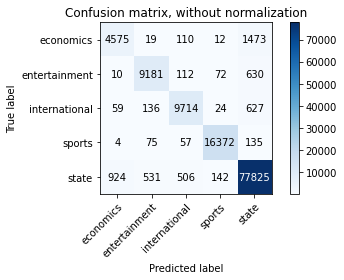

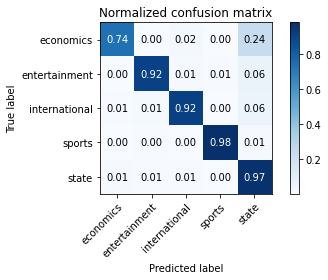

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_test, y_test_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=label, yticklabels=label,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.xlim(-0.5, len(np.unique(y_test))-0.5) # ADD THIS LINE
    plt.ylim(len(np.unique(y_test))-0.5, -0.5) # ADD THIS LINE
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_test_pred, classes=label,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_test_pred, classes=label, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

# **Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
Rmodel = RandomForestClassifier ( n_estimators=100 )

In [ ]:
Rmodel . fit ( sent_vectors , y_train )

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

# **CROSS VALIDATION**

In [ ]:
accuracy = cross_val_score(Rmodel, sent_vectors_cv, y_cv, scoring='accuracy', cv = 10)
print(accuracy)

[0.94481423 0.93706886 0.93997338 0.93755295 0.94057848 0.9390052
 0.93646375 0.94118359 0.94008715 0.93851368]


In [ ]:
print("Accuracy of Model with Cross Validation is:",accuracy.mean() * 100)

# **CLASSIFICATION REPORT**

In [ ]:
from sklearn . metrics import classification_report
from sklearn . model_selection import cross_val_score

y_test_pred  = Rmodel . predict ( sent_vectors_test )
y_train_pred = Rmodel . predict(sent_vectors)

In [ ]:
#training accuracy
print ( 'Model accuracy %s' % accuracy_score ( y_train , y_train_pred ) )

Model accuracy 0.999982117203846


In [ ]:
print ( 'Model accuracy %s' % accuracy_score ( y_test , y_test_pred ) )
print ( 'accuracy normalized %s' % accuracy_score ( y_test , y_test_pred , normalize = False ) )
print ( classification_report ( y_test , y_test_pred,target_names=label) )

Model accuracy 0.9440421650111493
accuracy normalized 116424
              precision    recall  f1-score   support

         eco       0.84      0.70      0.76      6189
         ent       0.91      0.89      0.90     10005
         int       0.91      0.85      0.88     10560
        sprt       0.98      0.97      0.98     16643
       state       0.95      0.98      0.96     79928

    accuracy                           0.94    123325
   macro avg       0.92      0.88      0.90    123325
weighted avg       0.94      0.94      0.94    123325



Confusion matrix, without normalization
[[ 4323    20    92    12  1742]
 [    5  8911   145    95   849]
 [   51   186  9009    27  1287]
 [    7   133   103 16133   267]
 [  765   493   501   121 78048]]
Normalized confusion matrix
[[6.98e-01 3.23e-03 1.49e-02 1.94e-03 2.81e-01]
 [5.00e-04 8.91e-01 1.45e-02 9.50e-03 8.49e-02]
 [4.83e-03 1.76e-02 8.53e-01 2.56e-03 1.22e-01]
 [4.21e-04 7.99e-03 6.19e-03 9.69e-01 1.60e-02]
 [9.57e-03 6.17e-03 6.27e-03 1.51e-03 9.76e-01]]


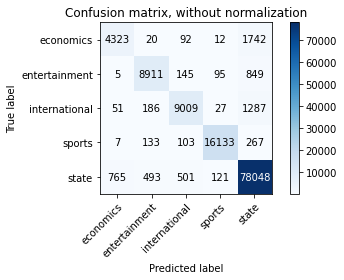

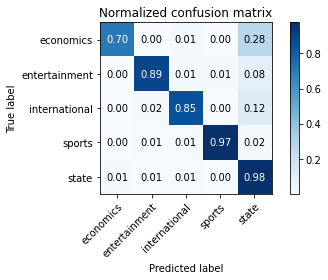

In [ ]:
label=np.array(['economics', 'entertainment', 'international', 'sports', 'state'], dtype=object)

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_test, y_test_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=label, yticklabels=label,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.xlim(-0.5, len(np.unique(y_test))-0.5) # ADD THIS LINE
    plt.ylim(len(np.unique(y_test))-0.5, -0.5) # ADD THIS LINE
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_test_pred, classes=label,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_test_pred, classes=label, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

# **Decission Tree**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
Dmodel = DecisionTreeClassifier ()                

In [ ]:
Dmodel . fit ( sent_vectors , y_train )

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

# **CROSS VALIDATION**

In [ ]:
accuracy = cross_val_score(Dmodel, sent_vectors_cv, y_cv, scoring='accuracy', cv = 10)
print(accuracy)

[0.89 0.88 0.89 0.89 0.89 0.89 0.88 0.89 0.89 0.88]


In [ ]:
print("Accuracy of Model with Cross Validation is:",accuracy.mean() * 100)

Accuracy of Model with Cross Validation is: 88.70600475126993


In [ ]:
y_test_pred  = Dmodel . predict ( sent_vectors_test )
y_train_pred = Dmodel . predict(sent_vectors)

In [ ]:
#trainaccuracy
print ( 'Model accuracy %s' % accuracy_score ( y_train , y_train_pred ) )

Model accuracy 0.9999880781358973


In [ ]:
print ( 'Model accuracy %s' % accuracy_score ( y_test , y_test_pred ) )
print ( 'accuracy normalized %s' % accuracy_score ( y_test , y_test_pred , normalize = False ) )
print ( classification_report ( y_test , y_test_pred,target_names = label ) )

Model accuracy 0.8970687208595175
accuracy normalized 110631
               precision    recall  f1-score   support

    economics       0.64      0.65      0.65      6189
entertainment       0.82      0.81      0.81     10005
international       0.77      0.76      0.77     10560
       sports       0.94      0.94      0.94     16643
        state       0.94      0.94      0.94     79928

     accuracy                           0.90    123325
    macro avg       0.82      0.82      0.82    123325
 weighted avg       0.90      0.90      0.90    123325



Confusion matrix, without normalization
[[ 4035    69   198    74  1813]
 [   61  8118   356   331  1139]
 [  213   349  8067   239  1692]
 [   81   294   232 15593   443]
 [ 1930  1122  1631   427 74818]]
Normalized confusion matrix
[[0.65 0.01 0.03 0.01 0.29]
 [0.01 0.81 0.04 0.03 0.11]
 [0.02 0.03 0.76 0.02 0.16]
 [0.   0.02 0.01 0.94 0.03]
 [0.02 0.01 0.02 0.01 0.94]]


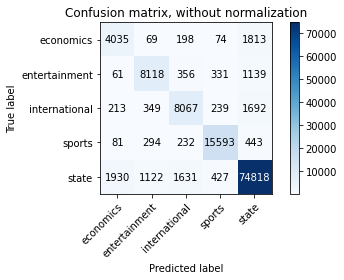

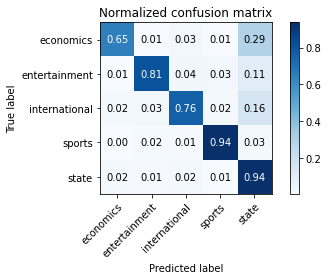

In [ ]:
label=np.array(['economics', 'entertainment', 'international', 'sports', 'state'], dtype=object)
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_test, y_test_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=label, yticklabels=label,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.xlim(-0.5, len(np.unique(y_test))-0.5) # ADD THIS LINE
    plt.ylim(len(np.unique(y_test))-0.5, -0.5) # ADD THIS LINE
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_test_pred, classes=label,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_test_pred, classes=label, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

# **Multinomial Naivebayes(sklearn data transformation)**

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import Binarizer
Mmodel=make_pipeline(Binarizer(), MultinomialNB())

In [ ]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(sent_vectors_train)
sent_vectors_train_transformed = scaler.transform(sent_vectors_train)

In [ ]:
Mmodel.fit(sent_vectors_train_transformed, y_train)

# CROSS VALIDATION 

In [ ]:
#using k-fold
accuracy = cross_val_score(Mmodel, sent_vectors_cv, y_cv, scoring='accuracy', cv = 10)
print(accuracy)

[0.8446085  0.85320102 0.84884425 0.85053855 0.84981242 0.84884425
 0.85320102 0.84823914 0.8479787  0.85052046]


In [ ]:
print("Accuracy of Model with Cross Validation is:",accuracy.mean() * 100)

Accuracy of Model with Cross Validation is: 84.95788272921789


In [ ]:
sent_vectors_test_transformed = scaler.transform(sent_vectors_test)
y_test_pred  = Mmodel. predict ( sent_vectors_test_transformed )
y_train_pred = Mmodel.predict (sent_vectors)

In [ ]:
from sklearn import metrics
from sklearn . metrics import accuracy_score

In [ ]:
#train accuracy
print ( 'Model accuracy %s' % accuracy_score ( y_train , y_train_pred ) )

Model accuracy 0.858857050888477


In [ ]:
from sklearn import metrics
from sklearn . metrics import accuracy_score
from sklearn.metrics import classification_report


In [ ]:
print ( 'Model accuracy %s' % accuracy_score ( y_test , y_test_pred ) )
print ( 'accuracy normalized %s' % accuracy_score ( y_test , y_test_pred , normalize = False ) )
print ( classification_report ( y_test , y_test_pred,target_names=label ))

Model accuracy 0.8422704236772754
accuracy normalized 103873
              precision    recall  f1-score   support

         eco       0.41      0.89      0.56      6189
         ent       0.74      0.91      0.82     10005
         int       0.60      0.84      0.70     10560
        sprt       0.98      0.93      0.95     16643
       state       0.97      0.81      0.88     79928

    accuracy                           0.84    123325
   macro avg       0.74      0.87      0.78    123325
weighted avg       0.89      0.84      0.86    123325



In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

Confusion matrix, without normalization
[[ 5499    47   116     8   519]
 [   99  9077   187   107   535]
 [  329   533  8838    45   815]
 [  155   329   375 15433   351]
 [ 7326  2228  5224   124 65026]]
Normalized confusion matrix
[[0.89 0.01 0.02 0.   0.08]
 [0.01 0.91 0.02 0.01 0.05]
 [0.03 0.05 0.84 0.   0.08]
 [0.01 0.02 0.02 0.93 0.02]
 [0.09 0.03 0.07 0.   0.81]]


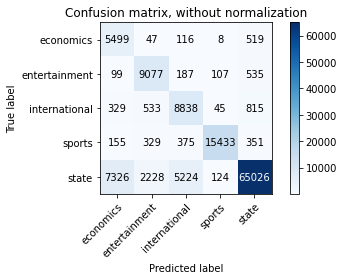

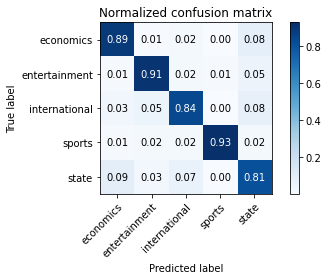

In [ ]:
label=np.array(['economics', 'entertainment', 'international', 'sports', 'state'], dtype=object)
def plot_confusion_matrix(y_test, y_test_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=label, yticklabels=label,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.xlim(-0.5, len(np.unique(y_test))-0.5) # ADD THIS LINE
    plt.ylim(len(np.unique(y_test))-0.5, -0.5) # ADD THIS LINE
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_test_pred, classes=label,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_test_pred, classes=label, normalize=True,
                      title='Normalized confusion matrix')

plt.show()